# Giới thiệu
- Bài báo cáo áp dụng 1 số kiến trúc mạng ***BackBone*** để phân loại tập dữ liệu hình ảnh của 5 loại giày khác nhau.
- Sử dụng 3 kiến mạng phổ biến ở hiện tại là: ***VGG16, ResNet50 và InterceptionV3*** để tìm ra ***BackBone*** tốt nhất cho tập dữ liệu.

# 1 - Chuẩn bị dữ liệu.

Source Dataset: [Shoes Dataset](https://www.kaggle.com/datasets/utkarshsaxenadn/shoes-classification-dataset-13k-images)
* Dataset mà tôi sử dụng có nguồn gốc từ Kaggle, bao gồm 5 loại giày khác nhau.
* Tôi sử dụng ***10000 ảnh cho tập huấn luyện (train 8000) và kiểm thử (valid 2000), 2500 ảnh cho tập kiểm tra (test)***.
* Dataset đã được tiền xử lý và đưa về (224, 224, 3).

* Mục tiêu chính của bài toán phân loại này là tìm ra mối quan hệ, mẫu hoặc đặc trưng của các loại giày để có thể dự đoán nhãn của các ảnh chưa được biết trước.

## 1.1 Tải và uzip Dataset.

In [ ]:
%%shell
#https://drive.google.com/file/d/1iJFCyjJwsGKPK0XUBg9cZ09lyyArF6Is/view?usp=sharing
pip -q install --upgrade --no-cache-dir gdown
gdown -q 1iJFCyjJwsGKPK0XUBg9cZ09lyyArF6Is
echo 'download: done => file: Shoes.zip'
rm -rf ./Shoes/
unzip -q Shoes.zip

## 1.2 Import các thư viện cần thiết.

In [ ]:
%%capture
!pip install wandb

import wandb
wandb.login(key="678dd8f878bad2e9206a6685f23d6b95a7686194") #key cho account WandB

In [ ]:
# Basic
import os
import numpy as np

# Data Viz
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Tensorflow for machine learning
import tensorflow as tf
import tensorflow.keras.utils as utils
import tensorflow.keras.applications as app
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout
from keras.models import load_model

# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from wandb.keras import WandbCallback

# Classification models
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3

import warnings
warnings.filterwarnings("ignore")

##1.3 Khảo sát tập dữ liệu.

### 1.3.1 Lấy danh sách các lớp của Dataset.

#### Tạo đường dẫn đến tập dữ liệu.

In [ ]:
path_to_train = '/content/Shoes/Data'
path_to_test = '/content/Shoes/Valid'

- path_to_train sẽ dùng để huấn luyện và đánh giá mô hình.
- path_to_test sẽ dùng để kiểm tra và hiển thị kết quả dự đoán.

#### Hiển thị các lớp của Dataset.

In [ ]:
class_names = list(filter(lambda f: os.path.isdir(os.path.join(path_to_train, f)),
                          os.listdir(path_to_train)))
class_names = sorted(class_names)
num_classes = len(class_names)
print(f"Số lớp của tập dữ liệu là: {num_classes}. \nClass Names: {class_names}")

Số lớp của tập dữ liệu là: 5. 
Class Names: ['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker']


* Đây là 5 lớp mà mô hình sẽ phân loại và dự đoán nhãn.

### 1.3.2 Trực quan số lượng ảnh của tập dữ liệu.

In [ ]:
def viz_class(x, NoD):
    class_names = list(filter(lambda f: os.path.isdir(os.path.join(x, f)),
                              os.listdir(x)))
    class_dis = [len(os.listdir(x + f"/{name}")) for name in class_names]
    lk_dis = dict(zip(class_names, class_dis))
    print(f"Class Distribution:\n{lk_dis}")

    fig = px.bar(x=class_dis, y=class_names, color=class_names, width=1000)
    fig.update_layout({'title': {'text': f'{NoD}', 'x': 0.5}},
                      xaxis_title="Số lượng mẫu",
                      yaxis_title="Các lớp của Dataset")
    fig.show()

In [ ]:
viz_class(path_to_train, "Train Set")

Class Distribution:
{'Brogue': 2000, 'Sneaker': 2000, 'Clog': 2000, 'Ballet Flat': 2000, 'Boat': 2000}


Tập train sẽ có 10 000 ảnh, mỗi có lớp 2000 ảnh.

In [ ]:
viz_class(path_to_test, 'Test Set')

Class Distribution:
{'Brogue': 500, 'Sneaker': 500, 'Clog': 500, 'Ballet Flat': 500, 'Boat': 500}


Tập test sẽ có 2500 ảnh, mỗi lớp có 500 ảnh.

* Với thông tin từ 2 biểu đồ trên, 2 tập train và test có dữ liệu cân bằng và không có lớp nào bị vượt trội dữ liệu hơn lớp nào.

### 1.3.3 Hiển thị 1 số ảnh của tập dữ liệu.

Found 10000 files belonging to 5 classes.


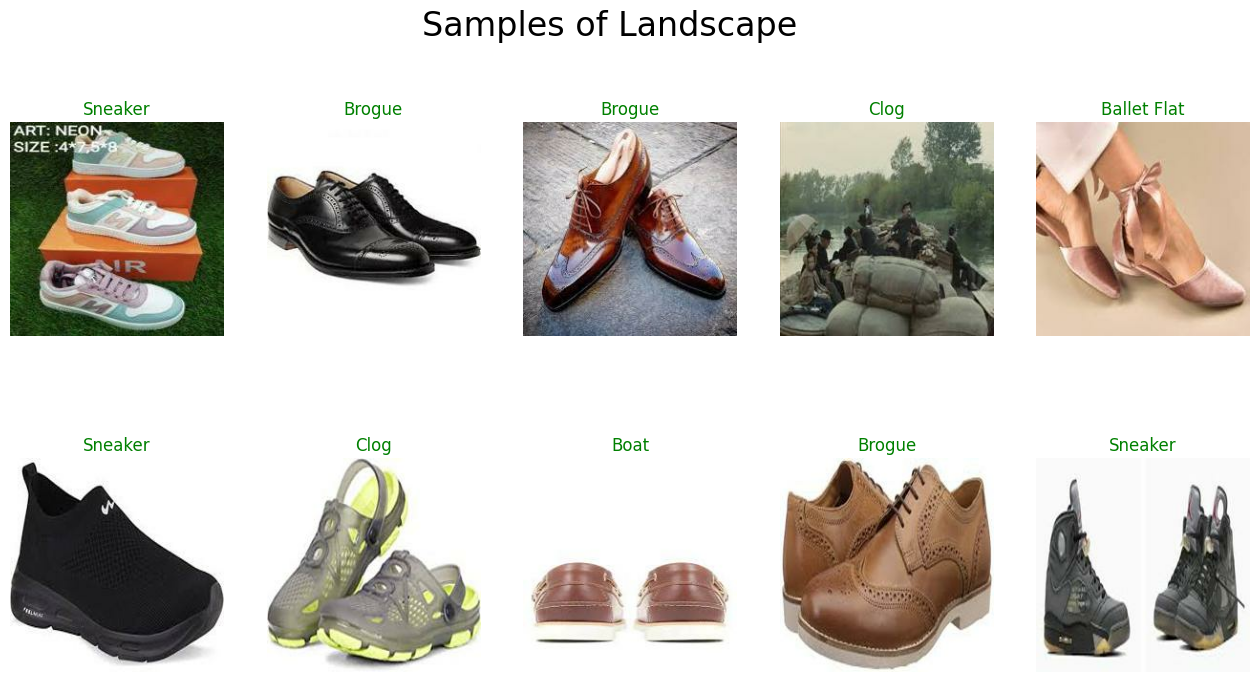

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
  path_to_train,
  image_size=(224, 224),
  batch_size=10,
  shuffle= True)

def show_images(dataset):
  plt.figure(figsize=(16,8))
  plt.suptitle('Samples of Landscape', fontsize=24)
  for images, labels in dataset.take(1):
    for i in range(10):
      ax = plt.subplot(2, 5, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]], color = 'g')
      ax.axis("off")
  plt.show()

show_images(dataset)

- Bên trên là 10 ảnh mẫu kèm theo nhãn đúng.

## 1.4 Định nghĩa kiến trúc cho 3 ***BackBone*** đã lựa chọn.


In [ ]:
feature_extractor = {
    "VGG16": VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    "ResNet50": ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    "InceptionV3": InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
}
preprocess_methods = {
    "VGG16": app.vgg16.preprocess_input,
    "ResNet50": app.resnet50.preprocess_input,
    "InceptionV3": app.inception_v3.preprocess_input
}
input_sizes = {
    "VGG16": (224, 224),
    "ResNet50": (224, 224),
    "InceptionV3": (299, 299)
}

# Define backbone list
backbones = ["VGG16", "ResNet50", "InceptionV3"]
batch_size = 64
epochs = 15

- Định nghĩa ba mô hình trích xuất đặc trưng: VGG16, ResNet50 và InceptionV3. Các mô hình này được sử dụng để trích xuất thông tin ảnh đầu vào. Mỗi mô hình được khởi tạo với các tham số như kích thước đầu vào, trọng số từ ImageNet và loại bỏ tầng fully-connected đầu ra (include_top).
- Định nghĩa thêm các phương thức tiền xử lý tương ứng và kích thước đầu vào cho từng mô hình.

Việc sử dụng ***Batch_size*** nhỏ sẽ giúp cho mô hình:
- Tăng tốc độ huấn luyện.
- Yêu cầu ít bộ nhớ.
- Độ chính xác của ***Dự đoán*** sẽ cao hơn.

Nhưng nó có thể gây mất ổn định hoặc bị hiện tượng ***Overfitting***.

## 1.5 Tạo tập huấn luyện và tập kiểm thử cho mô hình.

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)

train_set = generator.flow_from_directory(
    path_to_train,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='training')

valid_set = generator.flow_from_directory(
    path_to_train,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='validation')

Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


Tập train đã được chia thành 8000 ảnh cho huấn luyện và 2000 ảnh cho kiểm thử

In [ ]:
train_set.class_indices

{'Ballet Flat': 0, 'Boat': 1, 'Brogue': 2, 'Clog': 3, 'Sneaker': 4}

- Các chỉ số tương ứng với các lớp mà mô hình sẽ phân loại. Từ các chỉ số này mà khi dùng ***argmax*** ta có thể biết được ảnh thuộc lớp nào.

# 2 - Định nghĩa mô hình dự đoán:

## 2.1 Tạo kiến trúc cho mô hình:

* ***fextractor.trainable = False***: các tham số của mô hình sẽ không được cập nhật trong quá trình huấn luyện
* Nhằm đóng băng các phần của mô hình đã được huấn luyện trước đó và không cần phải cập nhật cho quá trình tiếp theo
=> Cải thiện hiệu suất huấn luyện và giảm thiểu nguy cơ ***overfitting***

In [ ]:
def create_model(backbone):
  fextractor = feature_extractor[backbone]
  fextractor.trainable = False

  model = keras.Sequential([
      fextractor,
      GAP(),
      Dense(num_classes, activation='softmax')
  ], name=backbone)
  return model

* ***GAP***, lớp pooling giúp giảm kích thước đặc trưng xuống còn 1 chiều -> ***FE (dense_1)*** để phân loại đầu ra.

## 2.2 Huấn luyện và lưu lại mô hình.

Vòng lặp tạo mô hình cho từng ***Backbone***.

In [ ]:
model_list = []
for backbone in backbones:
    # Create model
    model = create_model(backbone)
    model_list.append(model)

Tóm tắt các mô hình sử dụng.

In [ ]:
model_list[0].summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


***Phân tích về Backbone***:
* ***VGG16 *** là một mạng nơ-ron tích chập với 16 lớp (Conv) được xếp chồng lên nhau. Kiến trúc của VGG16 tập trung vào việc sử dụng các lớp tích chập với kích thước nhỏ (3x3) liên tiếp nhau để xây dựng một kiến trúc sâu hơn => Trích xuất các đặc trưng hình ảnh chi tiết.
* Phần ***Backbone*** chiếm hầu hết tham số (14,714,688), Số lượng tham số dùng để học là 10245 ( 5*512 + bias (5) tương ứng 5 lớp = 2565).

In [ ]:
model_list[1].summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


***Phân tích về Backbone***:
* ***ResNet50*** sẽ làm nhiệm vụ trích xuất các đặc trưng từ ảnh đầu vào thông qua 50 lớp tích chập (Conv) được xếp chồng lên nhau => đầu vào là ảnh, đầu ra là đặc trưng của ảnh.
* Phần ***Backbone*** chiếm hầu hết tham số (23,587,712), Số lượng tham số dùng để học là 10245 ( 5*2048 + bias (5) tương ứng 5 lớp = 10245).

In [ ]:
model_list[2].summary()

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


***Phân tích về Backbone***:
* ***InceptionV3*** là một kiến trúc mạng nơ-ron tích chập phức tạp hơn. Nó sử dụng khối Inception, một mô-đun với nhiều nhánh khác nhau, để trích xuất các đặc trưng từ ảnh. Kiến trúc InceptionV3 được tối ưu hóa để tăng hiệu suất và hiệu quả tính toán, đồng thời vẫn duy trì khả năng trích xuất đặc trưng mạnh mẽ
* Phần ***Backbone*** chiếm hầu hết tham số (21,802,784), Số lượng tham số dùng để học là 10245 ( 5*2048 + bias (5) tương ứng 5 lớp = 10245).

In [ ]:
%%capture
for backbone in backbones:
    # Create model
    model = create_model(backbone)

    # Define optimizer with learning rate schedule
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=5,
        decay_rate=0.95,
        staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Initialize wandb with the name of the backbone
    wandb.init(project='final_clf', name=backbone)

    # Define callbacks
    cbs = [
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(backbone + ".h5", save_best_only=True),
        WandbCallback()
    ]

    # Train model
    history = model.fit(
        train_set,
        validation_data=valid_set,
        callbacks=cbs,
        epochs=epochs,
        verbose=0
    )

Tạo một project wandb với tên là ***final_clf*** để lưu lại các chỉ số của 3 mô hình qua quá trình huấn luyện => vẽ biểu đồ đánh giá từ các chỉ số để ***so sánh và đánh giá***.

##2.3 Đánh giá mô hình qua quá trình huấn luyện:

[Biểu đồ đánh giá hiệu suất của mô hình qua từng Epochs](https://wandb.ai/clf_project/final_clf)
(đăng nhập bằng tài khoản wandb để xem chi tiết)


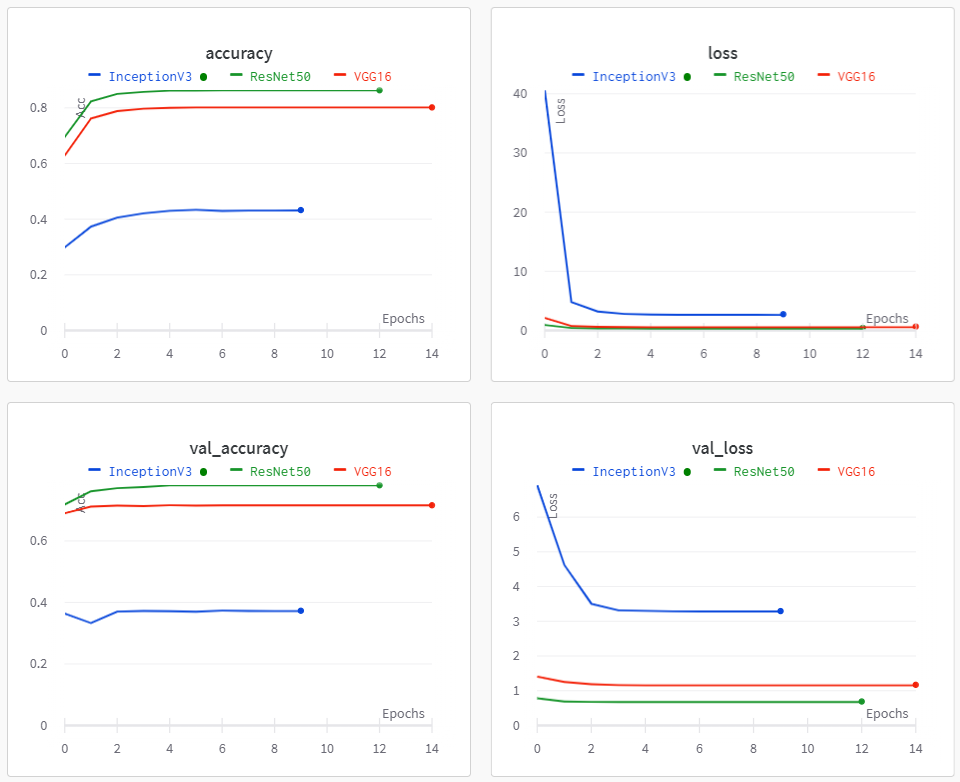

***Nhận xét thông quan biểu đồ***:
- Có thể thấy ResNet50 là backbone mang lại hiệu suất tốt nhất trong 3 kiến trúc. Chỉ số Accuracy - Val_accuracy lớn nhất và Chỉ số Loss - Val_loss cũng thấp nhất.
- VGG16 cũng thể hiện khá tốt khi các chỉ số cũng gần bằng với ResNet50.
- InterceptionV3 có lẽ là backbone tệ nhất, khi các chỉ số Acc - Loss không mấy khả quan so với 2 backbone còn lại.

***Đánh giá và lưu lại*** các chỉ số từ mô hình tốt nhất của từng kiến trúc mạng ***Backbone***.


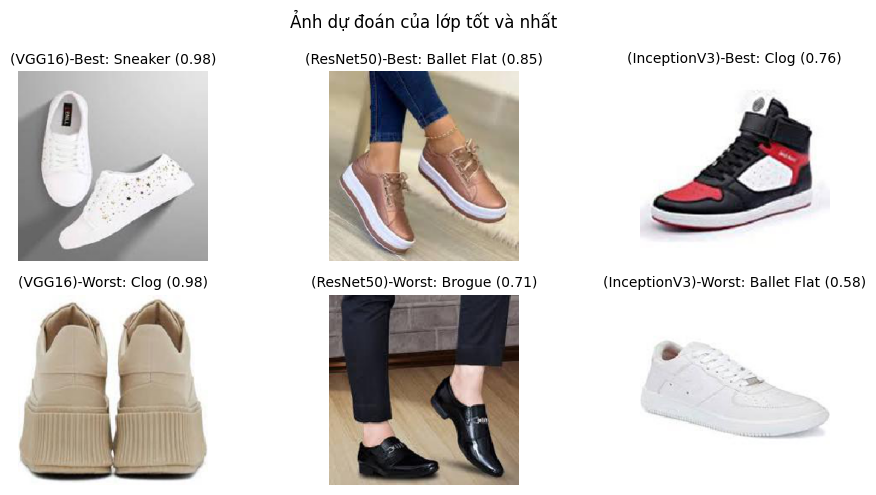

In [ ]:
# Định nghĩa các danh sách để tạo dataframe
accuracies = []
losses = []
results = []
metrics = ["Method","Val_Loss", "Val_Accuracy"]
label_table = ["Method","Best_pre_class", "Worst_pred_class"]
B_W = []

# Tạo 1 subplot với 2 hàng 3 cột
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i, backbone in enumerate(backbones):
    model = load_model(backbone + ".h5")

    val_loss, val_accuracy = model.evaluate(valid_set, verbose=0)

    accuracies.append(val_accuracy)
    losses.append(val_loss)
    results.append([backbone, val_loss, val_accuracy])

    predictions = model.predict(valid_set, verbose=0)
    confidence_scores = np.max(predictions, axis=1)

    best_class = np.argmax(predictions, axis=1)
    worst_class = np.argmin(predictions, axis=1)

    best_prediction = best_class[0]
    worst_prediction = worst_class[0]
    best_label = class_names[best_prediction]
    worst_label = class_names[worst_prediction]
    best_confidence = confidence_scores[best_prediction]
    worst_confidence = confidence_scores[worst_prediction]
    B_W.append([backbone, best_label, worst_label])

    valid_data = np.array(valid_set[0][0])
    valid_data_reshaped = valid_data.reshape(-1, 256, 256, 3)
    valid_data_reshaped = valid_data_reshaped / 255.0

    best_image = valid_data_reshaped[best_prediction]
    axs[0, i].imshow(best_image)
    axs[0, i].set_title(f'({backbone})-Best: {best_label} ({best_confidence:.2f})',size=10)
    axs[0, i].axis('off')

    worst_image = valid_data_reshaped[worst_prediction]
    axs[1, i].imshow(worst_image)
    axs[1, i].set_title(f'({backbone})-Worst: {worst_label} ({worst_confidence:.2f})',size=10)
    axs[1, i].axis('off')

fig.suptitle('Ảnh dự đoán của lớp tốt và nhất')
plt.tight_layout()
plt.show()

# Khởi tạo dataframe từ các danh sách đã được định nghĩa
tuned_table = pd.DataFrame(results, columns=metrics)
tuned_table = tuned_table.set_index("Method")

Best_class = pd.DataFrame(B_W, columns=label_table)
Best_class = Best_class.set_index("Method")


Đây là các hình ảnh của các lớp có dự đoán tốt nhất (Best) và tệ nhất (Worst) cho từng mô hình trên tập **Kiểm thử** (Valid)

In [ ]:
Best_class

,Best_pre_class,Worst_pred_class
Method,,
VGG16,Sneaker,Clog
ResNet50,Ballet Flat,Brogue
InceptionV3,Clog,Ballet Flat


Trực quan bằng bảng biểu để có cái nhìn tổng quát hơn.

## 2.4 Trực quan và so sánh.

Để cái nhìn trực quan hơn cho việc **so sánh và lựa chọn** backbone tốt nhất, thì 2 chỉ số **Accuracy và Loss** dựa trên tập **kiểm thử** là lý tưởng nhất.

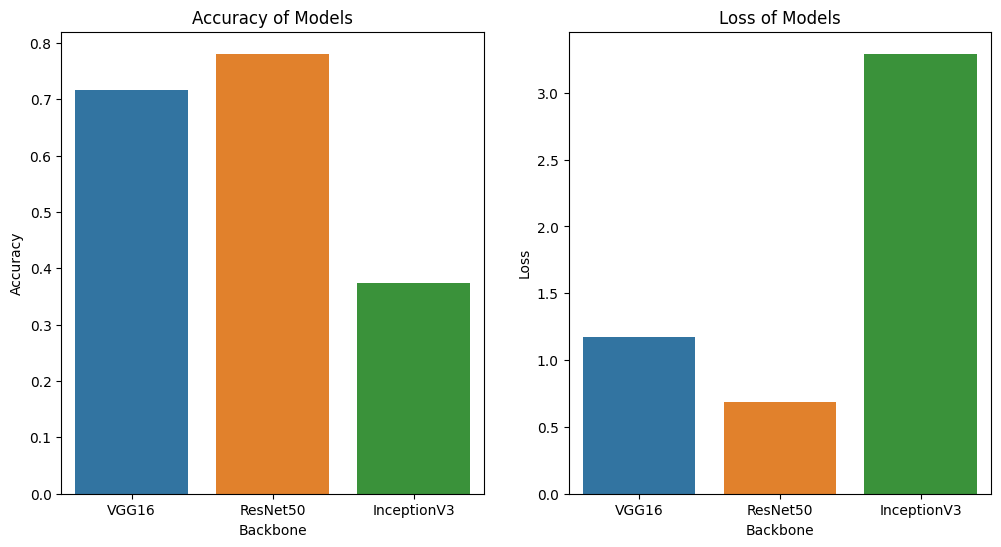

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Plot accuracy
sns.barplot(x=backbones, y=accuracies, ax=axes[0])
axes[0].set_xlabel("Backbone")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy of Models")

# Plot loss
sns.barplot(x=backbones, y=losses, ax=axes[1])
axes[1].set_xlabel("Backbone")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss of Models")

plt.show()

Thông qua biểu đồ thì **ResNet** có chỉ số tốt nhất, **VGG16** cũng không tệ lắm. Nhưng chỉ được chọn một mô hình tốt nhất để đánh giá hiệu suất trên tập kiểm tra sau khi đã hoàn thành quá trình huấn luyện.

#### 2.4.1 Lựa chọn mô hình tốt nhất.

In [ ]:
cm = sns.light_palette("purple", as_cmap=True)
tuned_table.style.background_gradient(cmap=cm).format(precision=3)

,Val_Loss,Val_Accuracy
Method,,
VGG16,1.171,0.716
ResNet50,0.690,0.781
InceptionV3,3.293,0.375


Thông qua 2 biểu đồ và Bảng chỉ số, ***ResNet50 sẽ*** là kiến trúc mạng Backbone tốt nhất và sẽ được lựa chọn để **dự đoán và hiển thị kết quả** trên tập kiểm tra (test_set).

### 2.4.2 Lấy ra mô hình tốt nhất.

In [ ]:
#Lưu thành file CSV
tuned_table.to_csv("tuned_results.csv", sep=";")

# Backbone tốt nhất:
best_backbone = tuned_table[tuned_table["Val_Accuracy"] == tuned_table["Val_Accuracy"].max()].dropna(axis=1)

#Lấy ra tên Backbone tốt nhất
model_name = best_backbone.index[0]
str(model_name)
best_backbone.style.background_gradient(cmap=cm).format(precision=3)

,Val_Loss,Val_Accuracy
Method,,
ResNet50,0.690,0.781


### 2.4.3 Load mô hình.

In [ ]:
model_file = f"{model_name}.h5".format(f"{model_name}")
trained_model = load_model(model_file)

# 3 - Triển khai mô hình tốt nhất với tập Test

## 3.1 Tải tập kiểm tra (Test_set).

* ***shuffle = True*** để có cái nhìn tổng quan hơn về dự đoán của mô hình thay vì chỉ có 1 lớp cho 1 batch.

In [ ]:
test_generator = ImageDataGenerator()
test_set = test_generator.flow_from_directory(
    path_to_test,
    target_size=input_sizes[f"{model_name}"],
    class_mode='binary',
    batch_size= batch_size,
    shuffle = True)

Found 2500 images belonging to 5 classes.


* Để có cái nhìn tổng quan hơn về dự đoán của mô hình cho các loại giày nên hiện tại ***shuffle = True***, Nếu như cần quan sát dự đoán trên 1 lớp thì suffle = False sẽ mang lại kết quả tốt nhất.

- Vì đã chọn được Backbone tốt nhất nên dùng **target_size=input_sizes[f"{model_name}"]** để scale ảnh đầu đúng với kích thước ảnh đầu vào của mô hình, tránh gây ra lỗi khi show ra dự đoán bên dưới.

## 3.2 Dự đoán ảnh trong một ***Batch*** và hiển thị kết quả.

### 3.2.1 Định nghĩa hàm hiển thị kết quả dự đoán (show_predictions).

In [ ]:
def show_predictions(dataset, model, backbone, purpose='all'):
    count = 0
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
    for images, labels in dataset:
        preprocess = preprocess_methods[f"{model_name}"]
        batch = preprocess(images.copy())
        probs = model.predict(batch, verbose=0)

        pred_labels = probs.argmax(axis=-1)
        pred_labels = [class_names[idx] for idx in pred_labels]
        ori_labels = [class_names[int(idx)] for idx in labels]
        confidence = probs.max(axis=-1)  # Lấy chỉ số confidence cao nhất

        for i in range(images.shape[0]):
            if count >= 10:  # Dừng sau khi hiển thị 10 dự đoán
                break

            if purpose == 'all' or (purpose == 'correct' and pred_labels[i] == ori_labels[i]) or (purpose == 'wrong' and pred_labels[i] != ori_labels[i]):
                ax = axes[count // 5, count % 5]
                ax.imshow(images[i].astype(np.uint8))

                if pred_labels[i] == ori_labels[i]:
                    color = 'g'
                else:
                    color = 'r'

                ax.set_title(f"Pred: {pred_labels[i]}-({ori_labels[i]})({confidence[i]:.2f})", color=color, size=10)
                ax.set(xticks=[], yticks=[])
                count += 1

        if count >= 10:
            break  # Dừng sau khi hiển thị 10 dự đoán

    if purpose == 'all':
        title = "Prediction results for images in a batch"
    elif purpose == 'correct':
        title = "Correct prediction results for images in a batch"
    elif purpose == 'wrong':
        title = "Wrong prediction results for images in a batch"

    fig.suptitle(title)
    plt.show()


Hàm trên được định nghĩa để hiển thị các dự đoán của mô hình. Với từng mục đích sử dụng mà hàm sẽ hiển thị các loại dự đoán khác nhau kèm theo chỉ số tin cậy (confidence) cho dự đoán đó.

### 3.2.2 Các dự đoán trong 1 batch (đúng và sai).

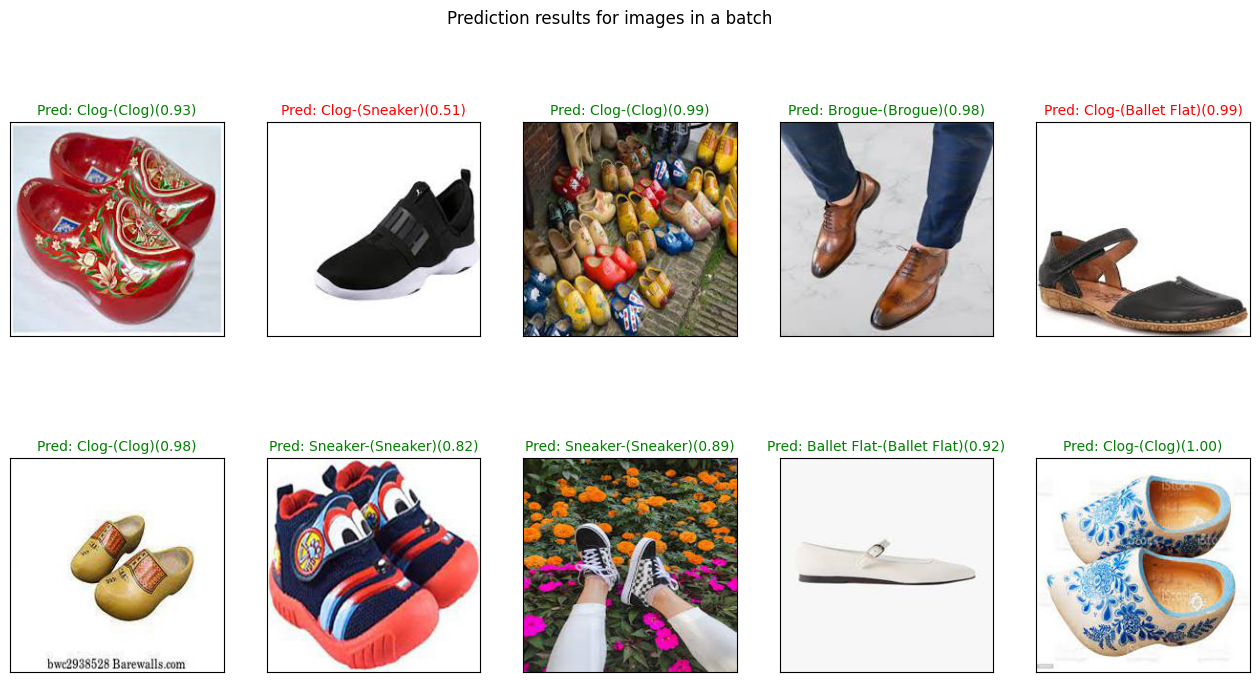

In [ ]:
show_predictions(test_set, trained_model, f"{model_name}", purpose='all')

Một số kết quả dự đoán của mô hình kèm theo chỉ số tin cậy (confidence) của dự đoán.

### 3.2.3 Dự đoán ***Chính xác***.

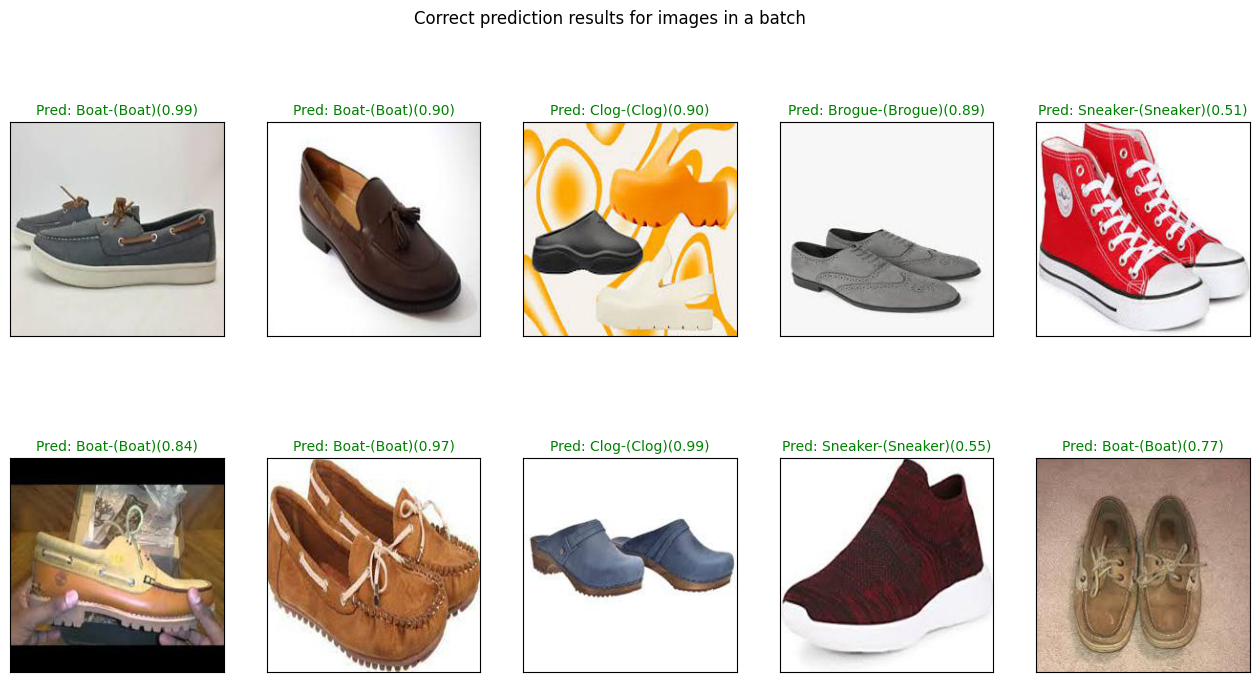

In [ ]:
show_predictions(test_set, trained_model, f"{model_name}", purpose='correct')

- Một số ảnh có mức độ tin cậy của dự đoán thấp, có thể mô hình không đủ thông tin hoặc không chắc chắn với dự đoán => Nguyên nhân có thể là do mô hình không được tiếp xúc đủ với các trường hợp tương tự của ảnh đó, vì thế mà mô hình không tự tin đủ để đưa ra dự đoán chính xác và mức độ sẽ thấp.

## 3.2.4 Dự đoán ***Sai***.

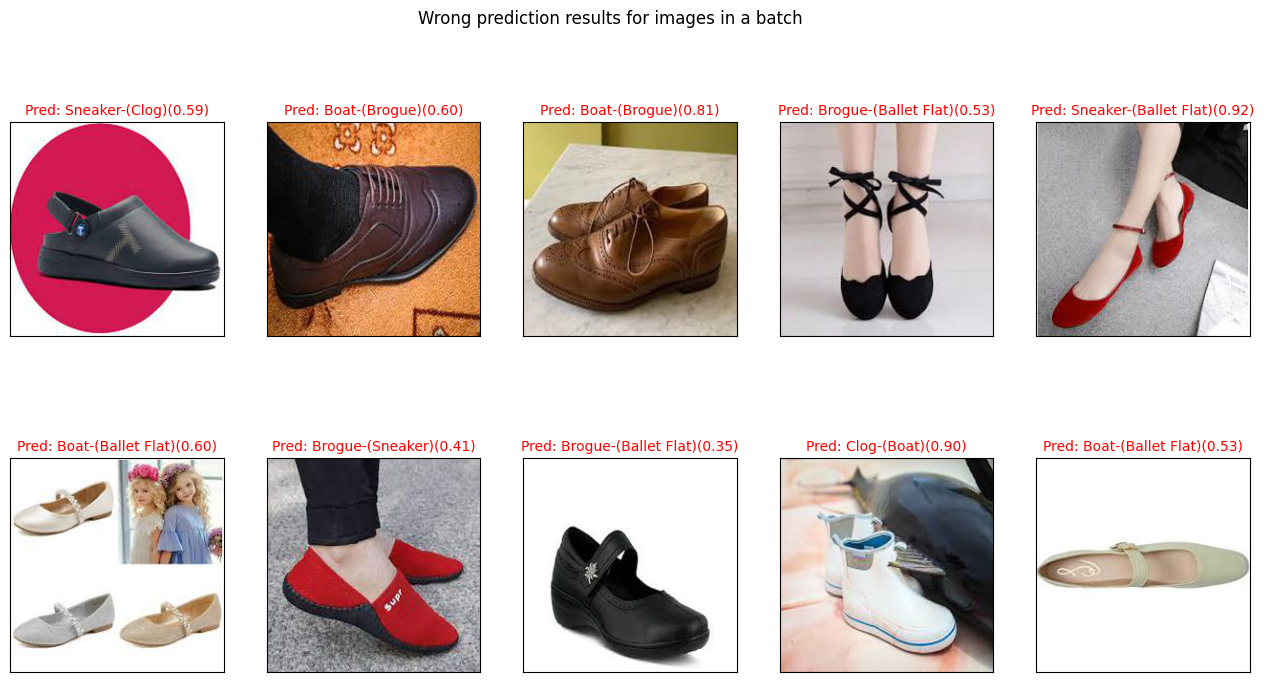

In [ ]:
show_predictions(test_set, trained_model, f"{model_name}", purpose='wrong')

- Tương tự như trên thì một phần là do tập dữ liệu chưa đủ đa dạng và không đại diện đủ cho các trường hợp cụ thể của lớp. Mô hình đã tìm thấy một số đặc điểm hoặc mẫu dữ liệu tương tự trong quá trình huấn luyện và dẫn đến sự tự tin cao trong việc dự đoán. Tuy nhêin, vì không có đủ thông tin hoặc kiến thức về trường hợp cụ thể của ảnh nên mô hình đã dự đoán sai.

# 4 - Kết luận.
- Tập dữ hình ảnh về 5 loại giày này vẫn còn nhiều chỗ cần cải thiện để mô hình có thể học tốt hơn.
- Các trường hợp khác nhau của từng loại giày (VD: vẫn là giày sneaker như có các ảnh từ các góc nhìn khác nhau).

In [ ]:
tuned_table.style.background_gradient(cmap=cm).format(precision=3)

,Val_Loss,Val_Accuracy
Method,,
VGG16,1.171,0.716
ResNet50,0.690,0.781
InceptionV3,3.293,0.375


Tiêu chí đánh giá:
- Độ chính xác cao.
- Mất mát ít.
- Thời gian chạy ngắn.
- Tốn ít tài nguyên khi huấn luyện.

3 kiến trúc mạng được chọn đều phổ biến ở thời điểm hiện tại nên việc tham khảo và cải tiến trong tương lai là điều hoàn toàn khả thi.
- Ưu điểm: dễ tiếp cận, nhận được sự hỗ trợ từ cộng đồng, tăng tính linh hoạt trong phát triển và triển khai.
- Nhược điểm: cần tập dữ liệu đa dạng và **lớn** để mô hình có thể học và trích xuất đặc trưng tốt hơn => tăng độ chính xác và khả năng tổng quát hóa, khám phá các đặc trưng phức tạp hơn.

Hướng phát triển trong tương lai:
- Train mô hình trên các tập dữ liệu đa dạng hơn.
- Tích hợp và show **WandB** trong quá trình huấn luyện.
- Tìm cách tăng hiệu suất của mô hình bằng các phương pháp khác.

Qua quá trình nghiên cứu, phân tích và huấn luyện 3 mô hình **VGG16, ResNet50, InceptionV3** => ***ResNet50*** là mô hình tốt nhất được lựa chọn phù hợp với tiêu chí đã đề ra.